# Flora MobileNet V3 Large Model with modefied weights for fine-tuning

### 1. Import Libraries

In [1]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torch.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from PIL import Image


### 2. Load Dataset

In [2]:
data_dir = './dataset'

### 3. Set Configurations

In [3]:
model_path = '../../saved_models/flora/flora_model.pt'
tscript_path = '../../saved_models/flora/scripted/flora_model.pt'
temp_model_path = os.path.join(os.path.dirname(model_path), "flora_model_temp.pt")

batch_size = 16
num_epochs = 15
num_classes = 9

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 4. Data Transforms and Dataset Setup

In [4]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

print("✅ Classes:", class_names)

✅ Classes: ['daffodil', 'daisy', 'dandelion', 'lotus', 'marigold', 'roses', 'sunflowers', 'tulips', 'windflower']


### 5. Load Model and Modify Classifier

In [5]:
model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)

# Freeze all layers
for param in model.features.parameters():
    param.requires_grad = False

# Unfreeze last few blocks for fine-tuning
for name, param in model.features.named_parameters():
    if "7" in name or "8" in name or "9" in name:
        param.requires_grad = True

# Replace final classifier layer
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
model = model.to(device)

### 6. Define Loss, Optimizer & Tracking Lists

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
scaler = GradScaler(device=device)

train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

best_val_acc = 0.0
early_stop_counter = 0
early_stop_patience = 5

### 7. Training and Validation Loop with Automatic Mixed Precision (AMP)

In [7]:
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type='cpu'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Save best to temp
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_counter = 0
        torch.save(model.state_dict(), temp_model_path)
        print(f"🔸 Improved! Temp model saved with Val Acc: {val_acc:.4f}")
    else:
        early_stop_counter += 1
        print(f"⚠️  No improvement. Early stop counter: {early_stop_counter}/{early_stop_patience}")

        if early_stop_counter >= early_stop_patience:
            print("🛑 Early stopping triggered!")
            break

Epoch 1/15 | Train Loss: 0.7404, Acc: 0.7603 | Val Loss: 0.4405, Acc: 0.8424
🔸 Improved! Temp model saved with Val Acc: 0.8424
Epoch 2/15 | Train Loss: 0.4492, Acc: 0.8521 | Val Loss: 0.3277, Acc: 0.8928
🔸 Improved! Temp model saved with Val Acc: 0.8928
Epoch 3/15 | Train Loss: 0.4054, Acc: 0.8612 | Val Loss: 0.3498, Acc: 0.8878
⚠️  No improvement. Early stop counter: 1/5
Epoch 4/15 | Train Loss: 0.3184, Acc: 0.8826 | Val Loss: 0.3514, Acc: 0.8777
⚠️  No improvement. Early stop counter: 2/5
Epoch 5/15 | Train Loss: 0.3283, Acc: 0.8855 | Val Loss: 0.3415, Acc: 0.8789
⚠️  No improvement. Early stop counter: 3/5
Epoch 6/15 | Train Loss: 0.3163, Acc: 0.8927 | Val Loss: 0.2800, Acc: 0.8941
🔸 Improved! Temp model saved with Val Acc: 0.8941
Epoch 7/15 | Train Loss: 0.2992, Acc: 0.8965 | Val Loss: 0.3225, Acc: 0.8941
⚠️  No improvement. Early stop counter: 1/5
Epoch 8/15 | Train Loss: 0.3019, Acc: 0.8972 | Val Loss: 0.3032, Acc: 0.8979
🔸 Improved! Temp model saved with Val Acc: 0.8979
Epoch 9/

### 8. Save Trained Final Model

In [8]:
if os.path.exists(temp_model_path):
    model_dir = os.path.dirname(model_path)
    existing_models = [f for f in os.listdir(model_dir) if f.startswith("flora_model_v") and f.endswith(".pt")]
    version_numbers = [int(f.split("_v")[-1].split(".pt")[0]) for f in existing_models if "_v" in f]
    next_version = max(version_numbers) + 1 if version_numbers else 1
    versioned_model_path = os.path.join(model_dir, f"flora_model_v{next_version}.pt")

    os.rename(temp_model_path, versioned_model_path)
    print(f"✅ Final model saved as versioned model: {versioned_model_path}")

✅ Final model saved as versioned model: ../../saved_models/flora\flora_model_v2.pt


### 9. Visualize Training Metrics

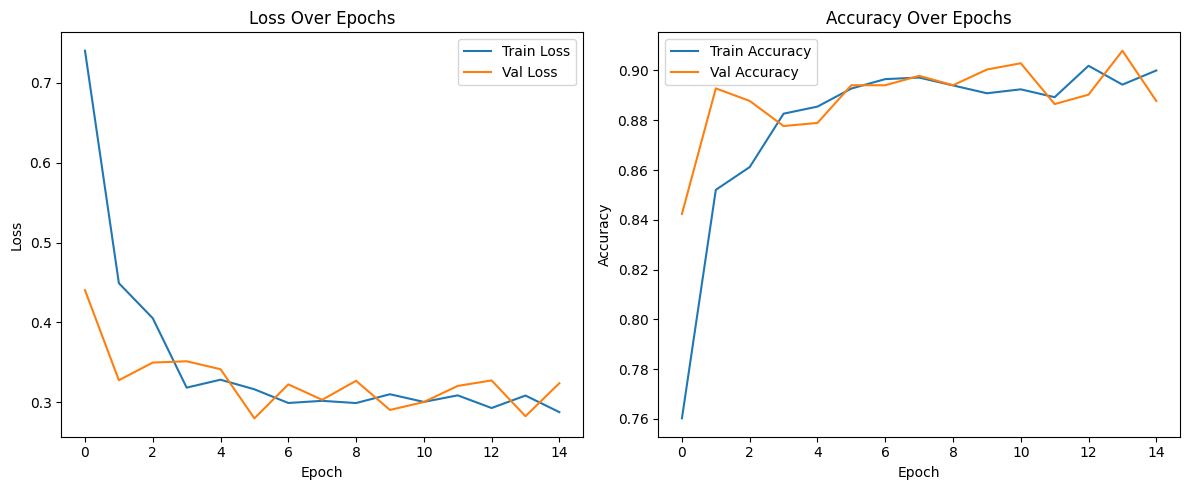

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

### 10. Export TorchScript Model

In [10]:
# Define directory and base model name
model_dir = os.path.dirname(tscript_path)
base_name = "flora_model_script_v"

# Create model directory if not exists
os.makedirs(model_dir, exist_ok=True)

# 🔄 Determine next version
existing_models = [
    f for f in os.listdir(model_dir)
    if f.startswith(base_name) and f.endswith(".pt")
]
version_numbers = [
    int(f.split("_v")[-1].split(".pt")[0])
    for f in existing_models if "_v" in f
]
next_version = max(version_numbers) + 1 if version_numbers else 1
versioned_path = os.path.join(model_dir, f"{base_name}{next_version}.pt")

# 🧠 Script and save model
scripted_model = torch.jit.script(model.cpu())
torch.jit.save(scripted_model, versioned_path)
print(f"✅ TorchScript model saved to: {versioned_path}")

✅ TorchScript model saved to: ../../saved_models/flora/scripted\flora_model_script_v2.pt


### 11. Inference Functions

In [11]:
def get_versioned_model_path(specific_version=None, latest=False):
    """
    Returns the path to a versioned model.

    Args:
        specific_version (int, optional): If provided, returns the path to that specific version.
        latest (bool): If True, returns the latest existing version. Defaults to False.

    Returns:
        str: The path to the appropriate versioned model.
    """
    model_dir = os.path.dirname(model_path)
    existing_models = [
        f for f in os.listdir(model_dir)
        if f.startswith("flora_model_v") and f.endswith(".pt")
    ]
    version_numbers = sorted([
        int(f.split("_v")[-1].split(".pt")[0])
        for f in existing_models if "_v" in f
    ])

    if specific_version is not None:
        return os.path.join(model_dir, f"flora_model_v{specific_version}.pt")

    if latest:
        if not version_numbers:
            return None
        return os.path.join(model_dir, f"flora_model_v{version_numbers[-1]}.pt")

    # If there's only one version, return it instead of generating a new one
    if len(version_numbers) == 1:
        return os.path.join(model_dir, f"flora_model_v{version_numbers[0]}.pt")

    # Default: return path for next version
    next_version = version_numbers[-1] + 1 if version_numbers else 1
    return os.path.join(model_dir, f"flora_model_v{next_version}.pt")

def load_model(model_path, num_classes):
    '''
    Loads the model from the specified path.

    Args:
        model_path (str): The path to the model file.
        num_classes (int): The number of classes in the dataset.

    Returns:
        nn.Module: The loaded model.
    '''

    model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
    model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def predict_image(image_path, model, transform, class_names):
    image = Image.open(image_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)

    predicted_class = class_names[predicted.item()]
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

def predict_images_in_folder(folder_path, model, transform, class_names):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        predict_image(img_path, model, transform, class_names)

### 12. Run Inference Functions on Test Images and Folder

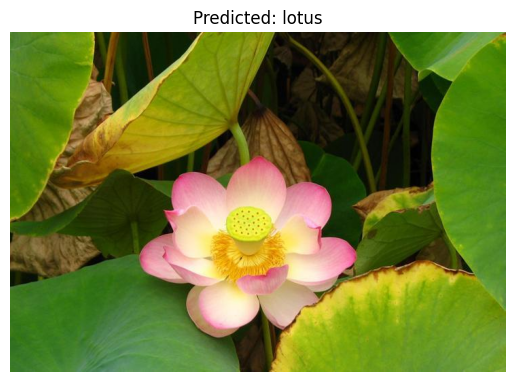

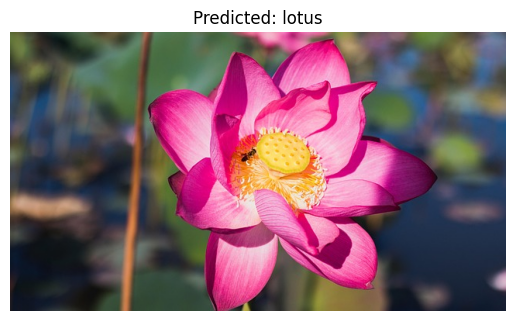

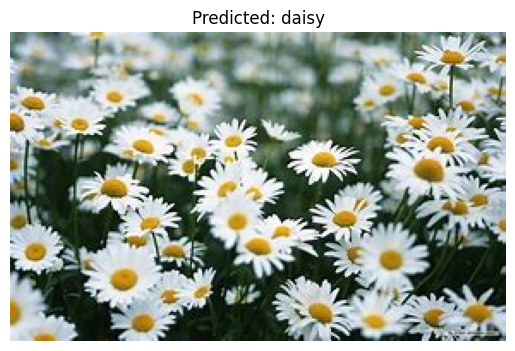

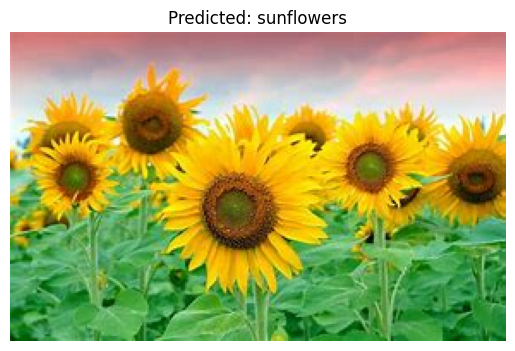

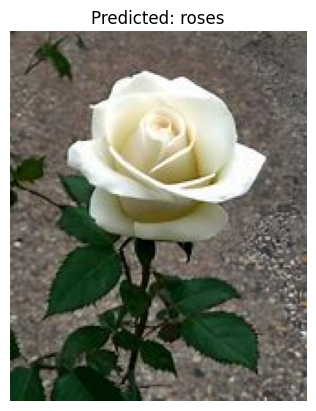

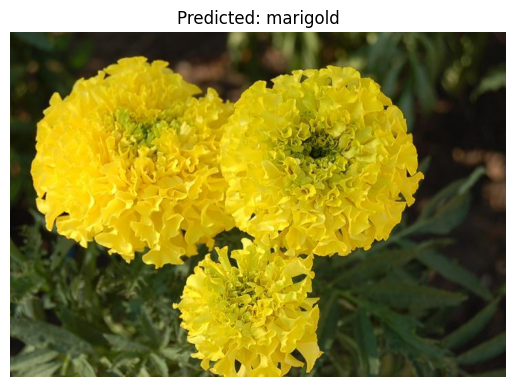

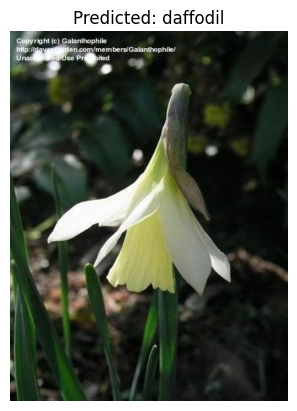

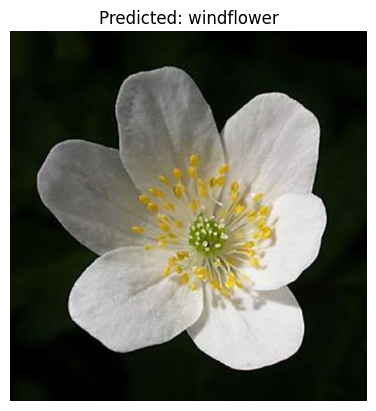

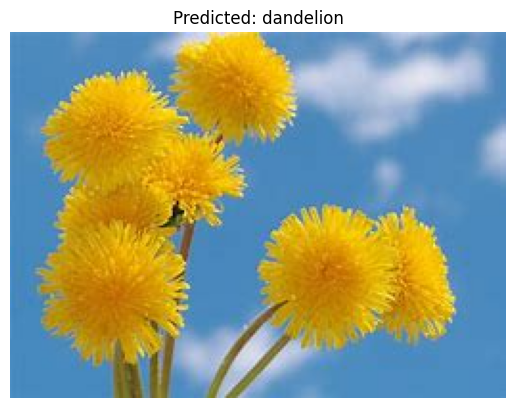

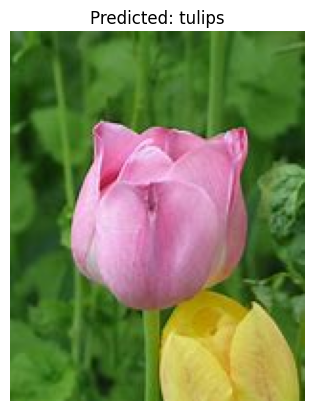

In [12]:
trained_model_path = get_versioned_model_path(latest=True)

model = load_model(trained_model_path, num_classes)
predict_image('./test_image.jpg', model, transform, class_names)
predict_images_in_folder('./test_flowers', model, transform, class_names)